# Проект для «Викишоп»

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

## Подготовка

In [16]:
! pip install torch
! pip install transformers
! pip install -U spacy-lookups-data
! pip install pandarallel
! pip install -U pip setuptools wheel
! pip install cupy-cuda12x
! pip install -U spacy[cuda]
! python -m spacy download en_core_web_sm

In [28]:
! pip install wordcloud

     -------------------------------------- 153.3/153.3 kB 1.0 MB/s eta 0:00:00


In [29]:
%matplotlib inline

In [43]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
from nltk.corpus import stopwords
from tqdm import tqdm
from tqdm import tqdm
from pandarallel import pandarallel
from wordcloud import WordCloud
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [55]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
    
except:
    data = pd.read_csv(r'C:\Users\Barbos-Rapitos\Desktop\practicum\text_ml\toxic_comments.csv', index_col=0)

In [56]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


<AxesSubplot:xlabel='toxic'>

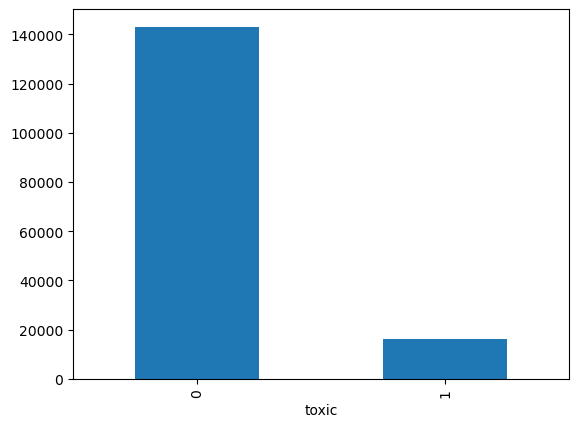

In [20]:
data.groupby(['toxic']).size().plot.bar()

### Вывод: 

Классы не сбалансированы. В датасете 159292 строк, 2 столбца. В столбце 'text' содержатся комментарии, в столбце 'toxic' целевой банарный признак, где 1 - токсичный комментарий, 0 не токсичный.

In [22]:
def clear_text(text):
    
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(text.split())

In [23]:
corpus = data['text'].apply(lambda x: clear_text(x))

In [24]:
nlp = spacy.load('en_core_web_sm')
spacy.prefer_gpu()

True

In [25]:
def parallel_lemma(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc]).lower()

In [26]:
corpus = corpus.progress_apply(parallel_lemma).values

 19%|█▉        | 30208/159292 [14:57<48:29, 44.36it/s]  WARNING: Ignoring invalid distribution -upy-cuda113 (c:\users\barbos-rapitos\anaconda3\lib\site-packages)
ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\Barbos-Rapitos\\anaconda3\\Lib\\site-packages\\cupy\\_util.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

 19%|█▉        | 30213/159292 [14:57<53:54, 39.91it/s]

  Using cached cupy-12.0.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for cupy: filename=cupy-12.0.0-cp39-cp39-win_amd64.whl size=64788353 sha256=abd5956103a043dfa882628dfafb9697d71b0d430902570e3e0b04c91b18ad85
  Stored in directory: c:\users\barbos-rapitos\appdata\local\pip\cache\wheels\d1\42\2d\80715fb03a139e048a6045e2008963f14db2b8d3102ee3e857
Successfully built cupy


100%|██████████| 159292/159292 [1:04:48<00:00, 40.97it/s]  


In [27]:
corpus

array(['explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york dolls fac and please don t remove the template from the talk page since i m retire now',
       'd aww he match this background colour i m seemingly stuck with thank talk january utc',
       'hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to i through edit instead of my talk page he seem to care more about the formatting than the actual info',
       ...,
       'spitzer umm there s no actual article for prostitution ring crunch captain',
       'and it look like it be actually you who put on the speedy to have the first version delete now that i look at it',
       'and i really don t think you understand i come here and my idea be bad right away what kind of community go you have bad idea go away instead of helping rewrite they'],
      dtype=object)

In [35]:
nltk.download("stopwords")
english_stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to C:\Users\Barbos-
[nltk_data]     Rapitos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
mas = []
for i in range(len(corpus)):
    mas.append(corpus[i].split())
    
words = []
for i in mas:
    for j in range(len(i)):
        words.append(i[j].lower())

In [42]:
clear_data=[]
for i in words:
    if(i not in english_stopwords):
        clear_data.append(i)

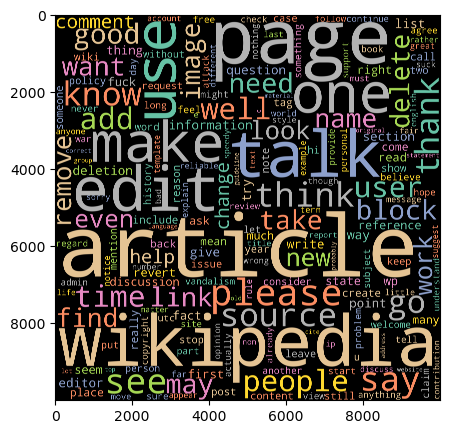

In [44]:
big_string=''
for i in range(len(clear_data)):
    big_string+=(clear_data[i]+' ')

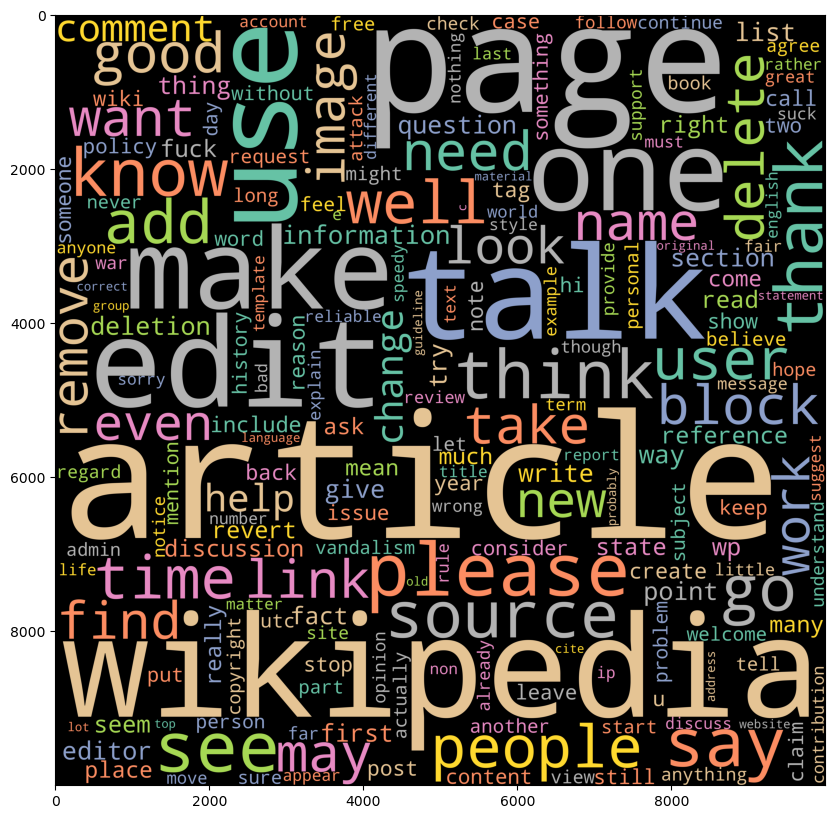

In [45]:
wordCloud = WordCloud(width = 10000, height = 10000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(big_string)
plt.figure(figsize=(10,10))
plt.imshow(wordCloud)

In [69]:
train_features, test_features, train_target, test_target = train_test_split(corpus, data['toxic'], test_size=0.2, random_state=42)

In [70]:
valid_features, test_features, valid_target, test_target = train_test_split(test_features, test_target, test_size=0.5, random_state=42)

In [71]:
train_features.shape, valid_features.shape, test_features.shape

((127433,), (15929,), (15930,))

In [72]:
count_tf_idf = TfidfVectorizer(stop_words=english_stopwords)
train_features = count_tf_idf.fit_transform(train_features)
valid_features = count_tf_idf.transform(valid_features)
test_features = count_tf_idf.transform(test_features)

## Обучение

In [80]:
logistic_model = LogisticRegression(class_weight='balanced', n_jobs=-1, C=10, random_state=42)
logistic_model.fit(train_features, train_target)
logistic_predict = logistic_model.predict(valid_features)


In [81]:
print('Метрика качества F1 для логистической регрессии:',f1_score(valid_target, logistic_predict))

Метрика качества F1 для логистической регрессии: 0.7656707674282366


In [82]:
lgbm_classifier = lgb.LGBMClassifier(
    colsample_bytree = 0.5, 
    learning_rate = 0.07552619413921881, 
    n_estimators = 1000, 
    num_leaves = 26, 
    reg_alpha = 0.05, 
    reg_lambda = 0, 
    subsample = 0.6633806094241483, 
    n_jobs=-1,
    random_state=42)

lgbm_classifier.fit(train_features, train_target)

clf_predict = lgbm_classifier.predict(valid_features)

In [76]:
print('Метрика качества F1 для LightGBM:',f1_score(valid_target, clf_predict))

Метрика качества F1 для LightGBM: 0.7778561354019746


In [79]:
clf_test_predict = lgbm_classifier.predict(test_features)
print('Метрика качества F1 для LightGBM на тестовой выборке:',f1_score(test_target, clf_test_predict))

Метрика качества F1 для LightGBM на тестовой выборке: 0.7782805429864253


In [ ]:
data_bert = data.sample(1500, weights='toxic', random_state=42)

In [ ]:
model_path = "JungleLee/bert-toxic-comment-classification"#"martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)
print(pipeline('This is a test text.'))

[{'label': 'non-toxic', 'score': 0.9996364116668701}]


In [ ]:
y_pred = []
for text in tqdm(data_bert['text']):
    pred = pipeline(text[:512])
    y_pred.append(1 if pred[0]['label'] == 'toxic' else 0)

100%|██████████| 1500/1500 [01:20<00:00, 18.65it/s]


In [ ]:
print('Метрика качества F1 для пердобученной BERT модели JungleLee:',f1_score(data_bert['toxic'], y_pred))

Метрика качества F1 для пердобученной BERT модели JungleLee: 0.9747095010252904


## Выводы

Данные были загружены и обработаны, текс был очищен, оставлены только буквенные значения. Лемматизация производилась с помощью лематизатора из SpaCy. При подсчете TF-IDF для корпуса текстов исключили стоп-слова.   
Созданы тренеровочная и тестовая и валидационная выборки.   
На них были обучены: LogisticRegression и LGBMClassifier.   
Метрика качества F1 для LogisticRegression на валидационной выборке составила 0.7656707674282366 
Метрика качества F1 для LightGBM на валидационной выборке составила 0.7778561354019746

Метрика качества F1 для LightGBM на тестовой выборке составила 0.7782805429864253
 
Были отобранны случайным порядком 1500 семплов из датасета, для тестирования предобученной модели BERT. 
Метрика качества F1 для пердобученной BERT модели JungleLee составила 0.9747095010252904


